# Solution to exercises week 43-44
#### Brage Wiseth, Eirik Jahr, Felix Cameren

In [54]:
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))

key = jax.random.PRNGKey(2024)


jax backend gpu


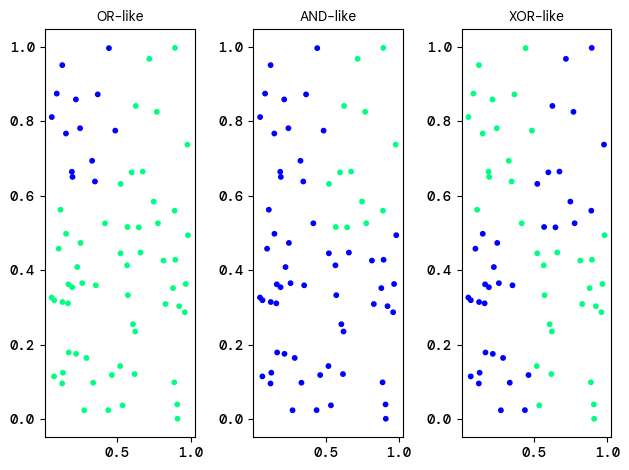

In [55]:
# we can generate a OR-like , AND-like and XOR-like dataset with float values
x = jax.random.uniform(key, shape=(70,2), minval=0, maxval=1)

t_or = (x[:,0] >= 0.5) | (x[:,1] < 0.6)
t_and = (x[:,0] >= 0.5) & (x[:,1] > 0.5)
t_xor = (x[:,0] >= 0.5) ^ (x[:,1] > 0.5)


fig, ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0],x[:,1], s=10, c=t_or, cmap='winter')
ax[0].set_title("OR-like", font='sans')
ax[1].scatter(x[:,0],x[:,1], s=10, c=t_and, cmap='winter')
ax[1].set_title("AND-like", font='sans')
ax[2].scatter(x[:,0],x[:,1], s=10, c=t_xor, cmap='winter')
ax[2].set_title("XOR-like", font='sans')
fig.tight_layout()
plt.show()


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler() # not using it for now

X_train, X_test, t_or_train, t_or_test = train_test_split(x, t_or, test_size=0.2, random_state=1234)
# same seed so we only need x_train and x_test from the first split
_ , _,   t_and_train , t_and_test = train_test_split(x, t_and, test_size=0.2, random_state=1234)
_ , _,   t_xor_train , t_xor_test = train_test_split(x, t_xor, test_size=0.2, random_state=1234)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

t_or_train = np.asarray(t_or_train).reshape(-1, 1)
t_or_test = np.asarray(t_or_test).reshape(-1, 1)
t_and_train = np.asarray(t_and_train).reshape(-1, 1)
t_and_test = np.asarray(t_and_test).reshape(-1, 1)
t_xor_train = np.asarray(t_xor_train).reshape(-1, 1)
t_xor_test = np.asarray(t_xor_test).reshape(-1, 1)


##  Optimizers

In [57]:
def create_update_sgd(eta, gamma):
    def sgd_update(params, grads, state ):
        momentum = state
        new_momentum = jax.tree_map(lambda m,g: gamma * m + eta * g, momentum, grads )
        new_params = jax.tree_map(lambda p, m: p - m, params, new_momentum)
        return new_params, new_momentum
    return sgd_update



def init_SGD_state(params):
    return jax.tree_map(lambda p: np.zeros_like(p), params)



# with momentum
def create_update_adagrad(eta=0.001,  epsilon=1e-8):
    def adagrad_update(params, grads, state ):
        v = state
        v = jax.tree_map(lambda v, g: v + g ** 2, v, grads)
        new_params = jax.tree_map(lambda p, v,g : p - eta * g / (np.sqrt(v) + epsilon), params, v, grads)
        return new_params, v
    return adagrad_update



def init_adagrad_state(params):
    return jax.tree_map(lambda p: np.zeros_like(p), params)  # Initialize second moment







def create_update_adam(eta=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    def adam_update(params, grads, state ):
        m, v, t = state
        m = jax.tree_map(lambda m_i, g_i: beta1 * m_i + (1 - beta1) * g_i, m, grads)
        v = jax.tree_map(lambda v_i, g_i: beta2 * v_i + (1 - beta2) * (g_i ** 2), v, grads)
        m_hat = jax.tree_map(lambda m_i: m_i / (1 - beta1 ** (t + 1)), m)
        v_hat = jax.tree_map(lambda v_i: v_i / (1 - beta2 ** (t + 1)), v)
        new_params = jax.tree_map(lambda p, m_h, v_h: p - (eta * m_h / (np.sqrt(v_h) + epsilon)), params, m_hat, v_hat)
        new_t = t + 1
        new_state = (m, v, new_t)
        return new_params, new_state
    return adam_update



def init_adam_state(params):
    ms = jax.tree_map(lambda p: np.zeros_like(p), params)  # Initialize first moment
    vs = jax.tree_map(lambda p: np.zeros_like(p), params)  # Initialize second moment
    ts = 0 
    return ms, vs, ts





def create_update_rmsprop(eta=0.001, gamma=0.9, epsilon=1e-8):
    def rmsprop_update(params, grads, state ):
        v = state
        v = jax.tree_map(lambda v,g : gamma * v + (1 - gamma) * (g ** 2), v, grads)
        new_param = jax.tree_map(lambda p,v,g: p - eta * g / (np.sqrt(v) + epsilon), params, v, grads)
        return new_param, v
    return rmsprop_update


def init_rmsprop_state(params):
    return jax.tree_map(lambda p: np.zeros_like(p), params)  # Initialize second moment

## Usefull definitions

In [58]:
@jax.jit
def CE(y, t):
    """
    Cross entropy loss function
    """
    return -np.mean(t * np.log(y) + (1 - t) * np.log(1 - y))




def build_forward(architecture):
    acitvation_functions = architecture[1]
    @jax.jit
    def last_layer_activation(network, inputs):
        activations = [inputs]
        for i in range(len(network)): 
            activations.append(acitvation_functions[i](np.dot(activations[-1], network[i]['w']) + network[i]['b']))
        return activations  
    @jax.jit
    def last_layer_no_activation(network, inputs):
        activations = [inputs]
        for i in range(len(network) - 1):
            activations.append(acitvation_functions[i](np.dot(activations[-1], network[i]['w']) + network[i]['b']))

        activations.append(np.dot(activations[-1], network[-1]['w']) + network[-1]['b'])
        return activations

    if len(architecture[0]) -  len(acitvation_functions ) > 1:
        return last_layer_no_activation
    else:
        return last_layer_activation




def sigmoid_derivative(x):
    return x * (1.0 - x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))



def single_layer_gradients(_, t, activations ):
    X, y = activations
    wgrad = (2/X.shape[0]) * np.dot(X.T , (y - t))
    bgrad = 2/X.shape[0] * np.sum(y - t)
    return [{'w': wgrad, 'b': bgrad}]



def init_network_params(layer_sizes, key):
    keys = jax.random.split(key, len(layer_sizes) - 1)
    return [{'w': jax.random.normal(k, (in_size, out_size)) * np.sqrt(2 / in_size),
             'b': np.zeros(out_size)}
            for k, in_size, out_size in zip(keys, layer_sizes[:-1], layer_sizes[1:])]



def progress_bar(current, total, bar_length=20):
    fraction = current / total

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    return f'Progress: [{arrow}{padding}] {int(fraction*100)}%'



def print_message(message):
    print(f"\r{message: <70}", end='')


class NN():

    def __init__(self ,architecture=[ [2, 2, 1], [sigmoid] ],
                eta=0.1, epochs=100, tol=0.001, optimizer='sgd', alpha=0,
                 gamma=0, epsilon=0.0001,  beta1=0.9, beta2=0.999, backwards=None, loss=CE):
        self.eta = eta
        self.epochs = epochs
        self.tol = tol
        self.optimizer = optimizer
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.architecture = architecture
        self.backwards = backwards
        self.forward = build_forward(architecture)


    def init_optimizer(self, params):
        match self.optimizer:
            case 'sgd':
                optimizer = create_update_sgd(self.eta, self.gamma)
                optimizerState = init_SGD_state(params)
                return optimizer, optimizerState
            case 'adagrad':
                optimizer = create_update_adagrad(self.eta, self.epsilon )
                optimizerState = init_adagrad_state(params)
                return optimizer, optimizerState
            case 'rmsprop':
                optimizer = create_update_rmsprop(self.eta, self.epsilon, self.gamma)
                optimizerState = init_rmsprop_state(params)
                return optimizer, optimizerState
            case 'adam':
                optimizer = create_update_adam(self.eta, self.beta1, self.beta2, self.epsilon)
                optimizerState = init_adam_state(params)
                return optimizer, optimizerState
            case _:
                raise ValueError(f"Unknown optimizer {self.optimizer}")



    def fit(self, X, t, X_val, t_val, batch_size=None ):
        N,n = X.shape
        self.architecture[0][0] = n
        if batch_size is None:
            batch_size = N
        key = jax.random.PRNGKey(1234)
        params = init_network_params(self.architecture[0], key)
        update_params, opt_state = self.init_optimizer(params) 
        batches = int(N/batch_size)
        loss = np.zeros(self.epochs)


        @jax.jit # one step of gradient descent jitted to make it zoom
        def step(params, opt_state, X, t):
            activations = self.forward(params, X)
            grads = self.backwards(params, t, activations, self.alpha)
            params, opt_state = update_params(params, grads, opt_state)
            return params, opt_state


        for e in range(self.epochs):
            for _ in range(batches):

                key, subkey = jax.random.split(key)
                random_index = batch_size * jax.random.randint(subkey, minval=0, maxval=batches, shape=())
                X_batch = X[random_index:random_index+batch_size]
                t_batch = t[random_index:random_index+batch_size]

                params, opt_state = step(params, opt_state, X_batch, t_batch)

                current_loss = CE(self.forward(params, X_val)[-1], t_val)

                # clip gradients
                if not np.isfinite(current_loss).all():
                    params = jax.tree_map(lambda p: np.clip(p, -100, 100), params)

                loss = loss.at[e].set(current_loss)

                # Early stopping condition
                if e > 10 and np.abs(loss[e-10] - loss[e]) < self.tol:
                    loss = loss.at[e+1:].set(loss[e]) 
                    break


        print_message(f"Training stopped after {e} epochs")
        return loss , params



## gradients

In [59]:
def backprop_one_hidden_auto( X,t, params, activations, alpha , loss=CE ):
    """cross entropy with sigmoid - sigmoid autoiff"""
    a0, a1 = activations
    dloss = jax.grad(loss)(a1, t)
    output_error = (a1 - t)
    hidden_error =  output_error @ params.w1.T * jax.grad(sigmoid) (a0)

    gw0 = X.T @ hidden_error
    gb0 = np.sum(hidden_error, axis=0)
    gw1 = a0.T @ output_error * dloss
    gb1 = np.sum(output_error, axis=0)

    return [{'w': gw0, 'b': gb0}, {'w': gw1, 'b': gb1}]




def backprop_one_hidden( params, t, activations, alpha):
    """Cross entropy with sigmoid - sigmoid"""
    X, a0, a1 = activations
    output_error = (a1 - t)
    hidden_error =  output_error @ params[1]['w'].T * a0 * (1 - a0) 

    gw0 = X.T @ hidden_error
    gb0 = np.sum(hidden_error, axis=0)
    gw1 = a0.T @ output_error
    gb1 = np.sum(output_error, axis=0)
    gw0, gb0, gw1, gb1 = jax.tree_map(lambda p: p / X.shape[0], (gw0, gb0, gw1, gb1))
    return [{'w': gw0, 'b': gb0}, {'w': gw1, 'b': gb1}]


def single_layer_gradients(_, t, activations , alpha):
    X, y = activations
    wgrad = (2/X.shape[0]) * np.dot(X.T , (y - t))
    bgrad = 2/X.shape[0] * np.sum(y - t)
    return [{'w': wgrad, 'b': bgrad}]

#### test and compare with jax to verify the derivations, not used in the analysis

In [60]:



loss = CE

def loss_all_args(w0,w1, b0, b1, X, T):
    """
    Loss function
    """
    a0 = sigmoid(X @ w0 + b0)
    a1 = sigmoid(a0 @ w1 + b1)
    return loss(a1, T)



# key, subkey = jax.random.split(key)
# params = ada.init_network_params([2,1], subkey)
# print(params)
# activations = forward_propagate(params, x)
# print(activations)
# print(t_train)
# grads = backprop_one_hidden(params, t_train, forward_propagate(params, X_train))
# grads = single_layer_gradients(params, t_train, forward_propagate(params, X_train))

# print(grads)
# print("#####")
# print(jax.grad(loss_all_args,argnums=(0,1,2,3))(params[0]['w'], params[1]['w'], params[0]['b'], params[1]['b'], X_train, t_train))

## Running the Neural Network

#### No hidden layer

In [61]:


sgd = NN(architecture=[[2,1],[ sigmoid ]], eta=0.1, epochs=1000, tol=0.01, optimizer='sgd', gamma=0.6,backwards=single_layer_gradients, loss=CE) 

loss_or, params_or = sgd.fit(X_train, t_or_train, X_test, t_or_test)
loss_and, params_and = sgd.fit(X_train, t_and_train, X_test, t_and_test)
loss_xor, params_xor = sgd.fit(X_train, t_xor_train, X_test, t_xor_test)

Training stopped after 999 epochs                                     

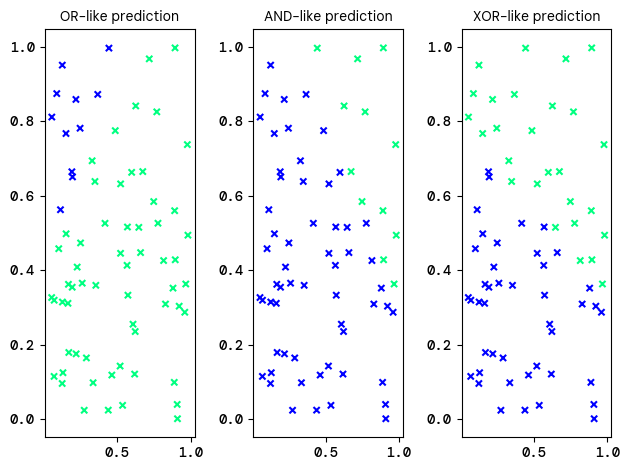

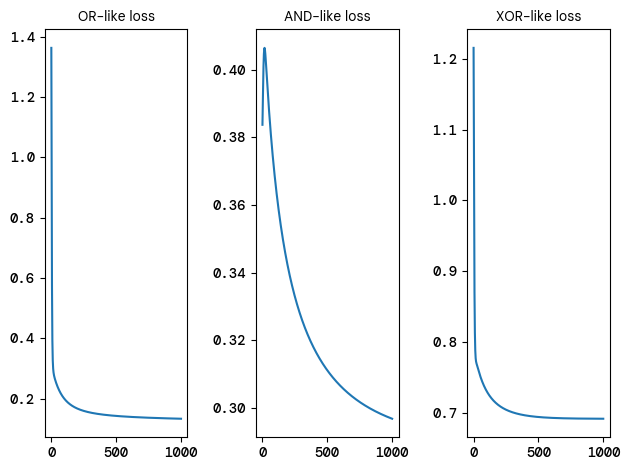

In [62]:


def predict(activations):
    return np.round(activations)


y_or = sgd.forward(params_or, x)[-1]
y_and = sgd.forward(params_and, x)[-1]
y_xor = sgd.forward(params_xor, x)[-1]


y_or = predict(y_or)
y_and = predict(y_and)
y_xor = predict(y_xor)


fig , ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0], x[:,1], s=20, c=y_or, cmap='winter', marker='x')
ax[0].set_title("OR-like prediction", font='sans')
ax[1].scatter(x[:,0], x[:,1], s=20, c=y_and, cmap='winter', marker='x')
ax[1].set_title("AND-like prediction", font='sans')
ax[2].scatter(x[:,0], x[:,1], s=20, c=y_xor, cmap='winter', marker='x')
ax[2].set_title("XOR-like prediction", font='sans')
fig.tight_layout()


fig, ax = plt.subplots(1, 3)
ax[0].plot(loss_or)
ax[0].set_title("OR-like loss", font='sans')
ax[1].plot(loss_and)
ax[1].set_title("AND-like loss", font='sans')
ax[2].plot(loss_xor)
ax[2].set_title("XOR-like loss", font='sans')
fig.tight_layout()
plt.show()

### One hidden layer

In [63]:

sgd = NN(architecture=[[2,4, 1],[ sigmoid, sigmoid ]], eta=0.1, epochs=1000, tol=0.001, optimizer='sgd', gamma=0.9,
backwards = backprop_one_hidden)
loss_or, params_or = sgd.fit(X_train, t_or_train, X_test, t_or_test)
loss_and, params_and = sgd.fit(X_train, t_and_train, X_test, t_and_test)
loss_xor, params_xor = sgd.fit(X_train, t_xor_train, X_test, t_xor_test)

Training stopped after 999 epochs                                     

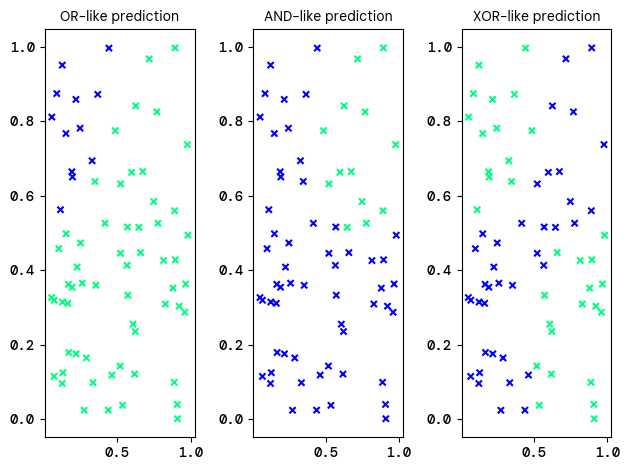

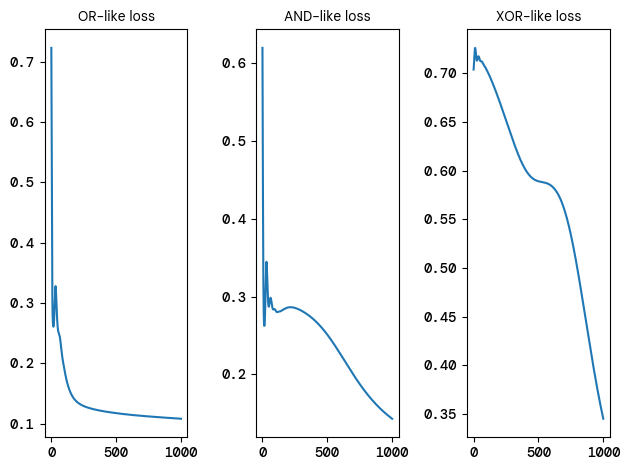

In [64]:
y_or = sgd.forward(params_or, x)[-1]
y_and = sgd.forward(params_and, x)[-1]
y_xor = sgd.forward(params_xor, x)[-1]


y_or = predict(y_or)
y_and = predict(y_and)
y_xor = predict(y_xor)


fig , ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0], x[:,1], s=20, c=y_or, cmap='winter', marker='x')
ax[0].set_title("OR-like prediction", font='sans')
ax[1].scatter(x[:,0], x[:,1], s=20, c=y_and, cmap='winter', marker='x')
ax[1].set_title("AND-like prediction", font='sans')
ax[2].scatter(x[:,0], x[:,1], s=20, c=y_xor, cmap='winter', marker='x')
ax[2].set_title("XOR-like prediction", font='sans')
fig.tight_layout()


fig, ax = plt.subplots(1, 3)
ax[0].plot(loss_or)
ax[0].set_title("OR-like loss", font='sans')
ax[1].plot(loss_and)
ax[1].set_title("AND-like loss", font='sans')
ax[2].plot(loss_xor)
ax[2].set_title("XOR-like loss", font='sans')
fig.tight_layout()
plt.show()

#### Compare with SKlearn

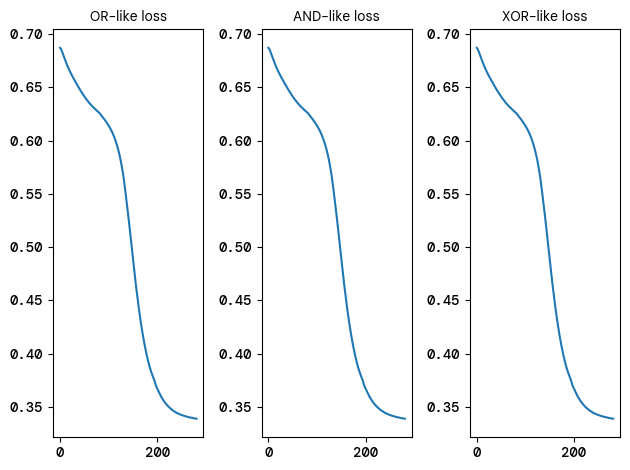

In [70]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(4,), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=0, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

mplor = mlp.fit(X_train, t_or_train.ravel())
mpland = mlp.fit(X_train, t_and_train.ravel())
mplxor = mlp.fit(X_train, t_xor_train.ravel())

loss_or = mplor.loss_curve_
loss_and = mpland.loss_curve_
loss_xor = mplxor.loss_curve_


fig, ax = plt.subplots(1, 3)
ax[0].plot(loss_or)
ax[0].set_title("OR-like loss", font='sans')
ax[1].plot(loss_and)
ax[1].set_title("AND-like loss", font='sans')
ax[2].plot(loss_xor)
ax[2].set_title("XOR-like loss", font='sans')
fig.tight_layout()
plt.show()


By adding one hidden layer we enable the network to learn linearly non-separable data. We see that the loss decresses from 0.7 to 0.35. This is a significant improvement. We also see that the loss is lower than the that of the SKlearn model. But they have a smoother loss curve for some reason